# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [25]:
# 필요한 라이브러리를 설치합니다.
!pip install timm
# --- [OpenCV 설치] ---
!pip install opencv-python-headless -q

# --- [추가] 텍스트 모델용 라이브러리 설치 ---
!pip install kobert-transformers -q
!pip install transformers -q
!pip install pytesseract -q
!sudo apt-get install tesseract-ocr tesseract-ocr-kor tesseract-ocr-eng -y -qq
!pip install --upgrade torch torchvision torchaudio

/bin/bash: sudo: command not found
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/70/1c/58da560016f81c339ae14ab16c98153d51c941544ae568da3cb5b1ceb572/torch-2.8.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/93/f3/3cdf55bbf0f737304d997561c34ab0176222e0496b6743b0feab5995182c/torchvision-0.23.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/d8/f5/69db76b564263f22c1788cc298ab1c4e2391a79fa8ba7b4a3e76d945292a/torchaudio-2.8.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.8.93 from https://files.

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [31]:
import os
#os.environ["WANDB_START_METHOD"] = "thread"
import time
import random
import glob

import cv2
import timm
import torch
import ttach as tta
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

# --- [추가] 텍스트 모델용 라이브러리 임포트 ---
from transformers import BertModel, BertTokenizer
from kobert_transformers import get_tokenizer
import pytesseract
import gc

In [ ]:
# --- 1. W&B 설치 및 로그인 ---

# W&B 라이브러리를 설치합니다.
!pip install wandb -q

# W&B에 로그인합니다.
# 실행 후 나오는 입력창에 복사해둔 API Key를 붙여넣으세요.
import wandb
wandb.login()

In [32]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [33]:
# --- [추가] 이미지 기울기 보정(Deskew) 함수 ---
def deskew(image, angle_threshold=1.0):
    """이미지의 기울기를 감지하고 보정합니다."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray) # 배경을 검정, 글자를 흰색으로
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    coords = np.column_stack(np.where(thresh > 0))
    if not coords.any():
        return image, 0.0 # 보정할 것이 없으면 원본 이미지와 0도 반환

    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # ✅ [핵심] 계산된 각도의 절대값이 임계값보다 작으면 보정하지 않고 원본을 반환
    if abs(angle) < angle_threshold:
        return image, angle
        
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated, angle

# --- [추가] 가로세로 비율 유지 리사이즈 및 패딩 함수 ---
def resize_and_pad(image, target_size=(224, 224)):
    """이미지의 가로세로 비율을 유지하며 리사이즈하고, 남는 공간을 패딩합니다."""
    h, w, c = image.shape
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    if new_w > target_w: new_w = target_w
    if new_h > target_h: new_h = target_h
        
    resized_image = cv2.resize(image, (new_w, new_h))
    
    pad_w = (target_w - new_w) // 2
    pad_h = (target_h - new_h) // 2
    
    padded_image = np.full((target_h, target_w, c), 0, dtype=np.uint8)
    padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized_image
    
    return padded_image

# --- [추가] 이미지 전처리 함수 (대비강화, 노이즈제거, 이진화) ---
def preprocess_image(image):
    """이미지를 받아 그레이스케일 변환, 대비 강화, 노이즈 제거, 이진화를 순서대로 적용합니다."""
    
    # 1. BGR -> 그레이스케일 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2. 대비 강화 (CLAHE: Contrast Limited Adaptive Histogram Equalization)
    #clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    #contrast_enhanced = clahe.apply(gray)

    # 3. 노이즈 제거 (가우시안 블러)
    #denoised = cv2.GaussianBlur(contrast_enhanced, (3, 3), 0)

    # 4. 이진화 (Otsu의 이진화)
    #_, binarized = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 5. 모델 입력을 위해 다시 3채널 BGR 이미지로 변환 (중요!)
    preprocessed_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    return preprocessed_image


# --- 데이터셋 클래스 정의 (고급 전처리 적용) ---
class ImageDataset(Dataset):
    def __init__(self, df, data_path, transform=None, img_size=224):
        self.df = df.values
        self.path = data_path
        self.transform = transform
        self.img_size = img_size # 모델별 이미지 크기를 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img_path = os.path.join(self.path, name)
        
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}.")
            # 문제가 있는 이미지는 건너뛰고 다음 이미지를 로드
            return self.__getitem__((idx + 1) % len(self.df))
        
        # --- 전처리 파이프라인 ---
        # 1. [추가] 이미지 전처리 (대비강화, 노이즈제거, 이진화)
        image = preprocess_image(image)
        
        # 2. 기울기 보정
        #image, _ = deskew(image, angle_threshold=1.0)
        
        # 3. 비율 유지 리사이즈 (모델별 img_size 적용)
        image = resize_and_pad(image, target_size=(self.img_size, self.img_size))
        
        # 4. Albumentations 데이터 증강
        if self.transform:
            image = self.transform(image=image)['image']
            
        return image, target

In [34]:
# --- [수정] one epoch 학습을 위한 함수 (AMP 적용) ---
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(loader, model, optimizer, loss_fn, device, accumulation_steps=1):
    scaler = GradScaler() # AMP를 위한 GradScaler 초기화
    model.train()
    train_loss = 0
    preds_list, targets_list = [], []
    optimizer.zero_grad()

    pbar = tqdm(loader)
    for i, (image, targets) in enumerate(pbar):
        image, targets = image.to(device), targets.to(device)

        # autocast 컨텍스트 안에서 연산을 수행하면 자동으로 FP16이 적용됩니다.
        with autocast():
            preds = model(image)
            loss = loss_fn(preds, targets)
            loss = loss / accumulation_steps

        # loss.backward() 대신 scaler를 사용합니다.
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer) # optimizer.step() 대신 scaler 사용
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())
        pbar.set_description(f"Loss: {loss.item()*accumulation_steps:.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')
    return {"train_loss": train_loss, "train_acc": train_acc, "train_f1": train_f1}

In [35]:
# --- [수정] 모델 평가를 위한 함수 (AMP 적용) ---
from torch.cuda.amp import autocast

def evaluate(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0
    preds_list, targets_list = [], []
    with torch.no_grad():
        for image, targets in tqdm(loader, desc="Validating"):
            image, targets = image.to(device), targets.to(device)

            with autocast(): # 추론 시에도 autocast 적용
                preds = model(image)
                loss = loss_fn(preds, targets)

            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    val_f1 = f1_score(targets_list, preds_list, average='macro')
    return {"val_loss": val_loss / len(loader), "val_f1": val_f1}

In [ ]:
# --- 2. EDA 및 W&B 리포팅 ---
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

# W&B Run 시작: EDA 과정을 기록할 프로젝트를 생성합니다.
with wandb.init(project="document-classification-eda", job_type="eda") as run:
    
    # 1. 원본 학습 데이터 로드
    full_train_df = pd.read_csv("/home/data/data/train.csv")
    
    # 2. W&B 테이블 생성: EDA 결과를 담을 표를 정의합니다.
    eda_table = wandb.Table(columns=[
        "ID", 
        "Image", 
        "Target", 
        "Width", 
        "Height", 
        "Aspect Ratio"
    ])
    
    # 3. 각 이미지의 정보를 테이블에 추가
    print("EDA 테이블을 생성하고 W&B에 업로드하는 중입니다...")
    for idx, row in tqdm(full_train_df.iterrows(), total=len(full_train_df)):
        image_id = row["ID"]
        target = row["target"]
        image_path = f"/home/data/data/train/{image_id}"
        
        # 이미지 파일을 열어 크기 정보 추출
        with Image.open(image_path) as img:
            width, height = img.size
            aspect_ratio = width / height if height > 0 else 0
        
        # 테이블에 행(row) 추가
        eda_table.add_data(
            image_id,
            wandb.Image(image_path), # 이미지를 W&B 형식으로 변환
            target,
            width,
            height,
            f"{aspect_ratio:.2f}"
        )
        
    # 4. 생성된 테이블을 W&B Run에 기록(log)
    run.log({"EDA_Table": eda_table})
    
    print("\n✅ W&B EDA 리포팅 완료! 위 wandb 링크를 클릭하여 대시보드를 확인하세요.")

In [ ]:
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import wandb

# W&B Run 시작: 테스트 데이터셋 EDA 과정을 기록할 프로젝트를 생성합니다.
with wandb.init(project="document-classification-test-eda", job_type="eda") as run:

    # 1. 테스트 데이터 로드 (sample_submission.csv 활용)
    test_df = pd.read_csv("/home/data/data/sample_submission.csv")

    # 2. W&B 테이블 생성: 테스트 데이터셋의 EDA 결과를 담을 표를 정의합니다.
    # 'target' 열이 없으므로 해당 열은 제외합니다.
    eda_table = wandb.Table(columns=[
        "ID",
        "Image",
        "Width",
        "Height",
        "Aspect Ratio"
    ])

    # 3. 각 테스트 이미지의 정보를 테이블에 추가
    print("테스트 데이터셋 EDA 테이블을 생성하고 W&B에 업로드하는 중입니다...")
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        image_id = row["ID"]
        # 테스트 이미지 경로 설정
        image_path = f"/home/data/data/test/{image_id}"

        # 이미지 파일을 열어 크기 정보 추출
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                aspect_ratio = width / height if height > 0 else 0
        except FileNotFoundError:
            # 혹시 모를 파일 누락에 대비
            width, height, aspect_ratio = -1, -1, -1

        # 테이블에 행(row) 추가
        eda_table.add_data(
            image_id,
            wandb.Image(image_path), # 이미지를 W&B 형식으로 변환
            width,
            height,
            f"{aspect_ratio:.2f}"
        )

    # 4. 생성된 테이블을 W&B Run에 기록(log)
    run.log({"Test_EDA_Table": eda_table})

    print("\n✅ W&B EDA 리포팅 완료! 위 wandb 링크를 클릭하여 대시보드를 확인하세요.")

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [47]:
# --- 기본 설정 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
data_path = 'datasets_fin/'
num_classes = 17 # 총 클래스 개수

# --- 앙상블을 위한 모델 목록 정의 ---
# 각 모델에 맞는 이름, 이미지 크기, 배치 사이즈를 딕셔너리 형태로 관리합니다.
model_configs = [
    #{
        #"model_name": 'convnext_xlarge_in22k',
        #"img_size": 384,
        #"batch_size": 2, # GPU 메모리 부족 시 8로 줄이세요.
    #},
    {
        "model_name": 'swin_large_patch4_window7_224',
        "img_size": 224,
        "batch_size": 16,
    },
    {
        "model_name": 'maxvit_base_tf_512',
        "img_size": 512,
        "batch_size": 4,
    }
    #{
        #"model_name": 'eva02_base_patch14_224.mim_in22k',
        #"img_size": 224,
        #"batch_size": 16,
    #}
]

# --- K-Fold 및 공통 학습 설정 ---
N_SPLITS = 2      # K-Fold 횟수 (시간이 부족하면 3으로 줄여서 테스트)
LR = 1e-4
EPOCHS = 30     # 최대 에폭 수. Early Stopping으로 조기에 중단될 수 있음.
PATIENCE = 4     # 조기 종료를 위한 대기 횟수
num_workers = 4

Using device: cuda


In [37]:
# --- [신규] 정제된 데이터 증강 전략 정의 ---

def get_transforms(img_size):
    """
    과한 왜곡은 줄이고, 현실적인 변형에 집중한
    정제된 데이터 증강(transform) 파이프라인을 반환하는 함수입니다.
    """
    # 학습용 데이터 증강 (정제된 버전)
    trn_transform = A.Compose([
        A.Resize(height=img_size, width=img_size),

        # --- 강도를 낮춘 기하학적 변형 ---
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=60, p=0.7), # 회전 각도와 크기 조절 강도 감소

        # 강력한 왜곡은 낮은 확률로 적용
        A.OneOf([
            A.Perspective(scale=(0.02, 0.05), p=0.7), # 왜곡 강도 감소
            A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.7), # 왜곡 강도 감소
            A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=0.7) # 왜곡 강도 감소
        ], p=0.4), # 적용 확률을 50% -> 40%로 낮춤

        # --- 현실적인 사진 품질 저하 ---
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7), # 대비 변화 강도 감소
        A.RandomShadow(p=0.4),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5), p=0.7), # 블러 강도 감소
            A.MotionBlur(blur_limit=(3, 5), p=0.7),
        ], p=0.4), # 적용 확률을 50% -> 30%로 낮춤

        A.ImageCompression(quality_lower=80, quality_upper=100, p=0.5), # 적용 확률 및 압축률 조정
        A.CoarseDropout(max_holes=4, max_height=int(img_size*0.08), max_width=int(img_size*0.08), min_holes=1, fill_value=0, p=0.3), # 구멍 크기와 개수, 확률 감소

        # 정규화 및 텐서 변환
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # 검증 및 테스트용은 동일
    tst_transform = A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return trn_transform, tst_transform

🎨 실제 학습 규칙에 따른 0번 이미지 증강 예시 (클래스: 16):


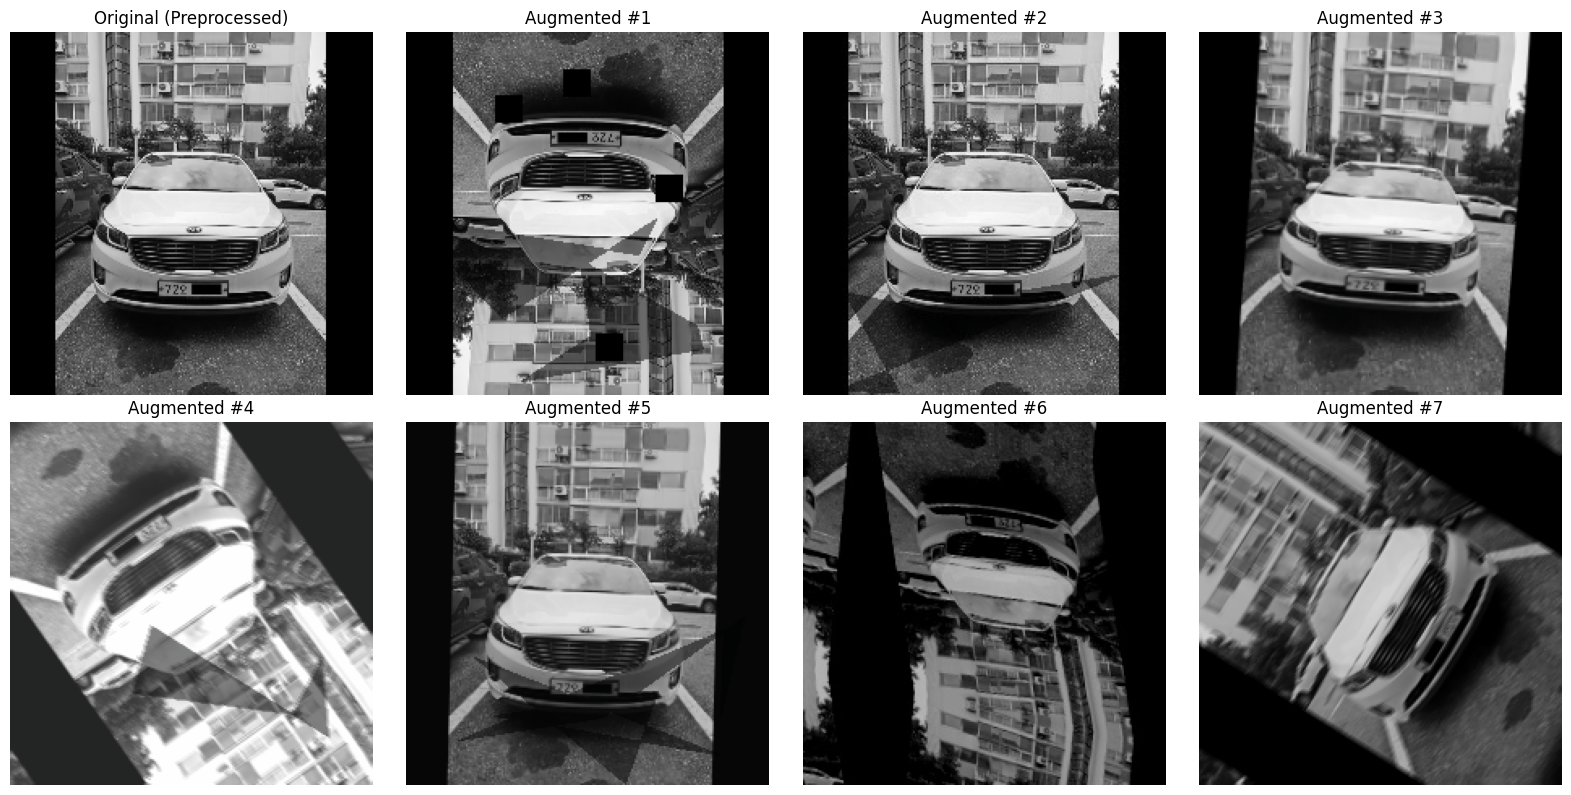

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

# --- [신규] 역정규화(Denormalize) 및 원본 이미지 로드 함수 ---

# 1. 시각화를 위해 정규화된 텐서를 다시 이미지로 변환하는 함수
def denormalize(tensor):
    # 정규화 시 사용했던 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # 텐서를 NumPy 배열로 변환하고 차원 순서를 (C, H, W) -> (H, W, C)로 변경
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    
    # 정규화 역연산: (img * std) + mean
    img = std * img + mean
    
    # 픽셀 값을 0-1 범위로 클리핑
    img = np.clip(img, 0, 1)
    
    return img

# 2. 증강 전 원본 이미지를 불러와서 실제 전처리를 적용하는 함수
def get_preprocessed_original(dataset, idx):
    # 데이터셋 내부 로직과 동일하게 원본 이미지를 로드하고 전처리
    name, _ = dataset.df[idx]
    img_path = os.path.join(dataset.path, name)
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # imshow를 위해 RGB로 변환
    
    image = preprocess_image(image) # 실제 사용하는 전처리 함수
    image = resize_and_pad(image, target_size=(dataset.img_size, dataset.img_size)) # 실제 사용하는 리사이즈 함수
    
    return image

# --- 실제 증강 규칙에 따른 시각화 ---

# 1. 실제 학습에 사용하는 get_transforms 함수를 그대로 사용
trn_transform, _ = get_transforms(img_size=224)
vis_df = pd.read_csv("/home/data/data/train.csv")

# 2. 실제 학습용 데이터셋을 생성
vis_dataset_real = ImageDataset(vis_df, "/home/data/data/train/", transform=trn_transform, img_size=224)

# 3. 증강된 모습을 보고 싶은 원본 이미지의 인덱스 선택
image_index_to_view = 0
original_label = vis_dataset_real.df[image_index_to_view][1]

print(f"🎨 실제 학습 규칙에 따른 0번 이미지 증강 예시 (클래스: {original_label}):")
plt.figure(figsize=(16, 8))

# 첫 번째 칸에는 '증강 전 원본' 이미지를 표시
plt.subplot(2, 4, 1)
original_image = get_preprocessed_original(vis_dataset_real, image_index_to_view)
plt.imshow(original_image)
plt.title("Original (Preprocessed)")
plt.axis('off')

# 나머지 7개 칸에는 동일한 원본 이미지가 다르게 증강된 결과를 표시
for i in range(7):
    # vis_dataset_real을 호출할 때마다 매번 다른 증강이 적용된 '텐서'가 반환됨
    augmented_tensor, _ = vis_dataset_real[image_index_to_view]
    
    # 텐서를 시각화 가능한 이미지로 변환
    augmented_image = denormalize(augmented_tensor)
    
    plt.subplot(2, 4, i + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented #{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [21]:
# --- 라이브러리 임포트 ---
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertModel
from kobert_transformers import get_tokenizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import os
import gc
import easyocr
import cv2

# --- 기본 설정 ---
print("\nSetting up for text model...")
DATA_PATH = "/home/data/data/"
TRAIN_IMAGE_PATH = os.path.join(DATA_PATH, "train/")
TEST_IMAGE_PATH = os.path.join(DATA_PATH, "test/")
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "train.csv")
OCR_TRAIN_CSV_PATH = os.path.join(DATA_PATH, "train_with_easyocr_preprocessed.csv")
OCR_TEST_CSV_PATH = os.path.join(DATA_PATH, "test_with_easyocr_preprocessed.csv")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Setting up for text model...


In [22]:
# --- EasyOCR 추출 및 보정 함수, 데이터 로드 ---
print("\nLoading data and performing OCR with pre-processing...")

# EasyOCR 리더 객체 초기화 (GPU 사용)
reader = easyocr.Reader(['ko', 'en'], gpu=torch.cuda.is_available())

def preprocess_for_ocr(image_path):
    """OCR 인식률 향상을 위한 이미지 보정 함수"""
    image = cv2.imread(image_path)
    if image is None: return None
    target_width = 1500
    ratio = target_width / image.shape[1]
    target_height = int(image.shape[0] * ratio)
    resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LANCZOS4)
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return binary_image

def extract_easyocr_text_with_preprocessing(image_id, base_path):
    """이미지 보정 후 EasyOCR로 텍스트를 추출하는 함수"""
    image_path = os.path.join(base_path, image_id)
    try:
        preprocessed_image = preprocess_for_ocr(image_path)
        if preprocessed_image is None: return ""
        result = reader.readtext(preprocessed_image)
        text_list = [text for _, text, _ in result]
        return ' '.join(text_list)
    except Exception as e:
        print(f"Error processing {image_id}: {e}")
        return ""

if not os.path.exists(OCR_TRAIN_CSV_PATH):
    print("Preprocessed EasyOCR training file not found. Creating new one...")
    ocr_df = pd.read_csv(TRAIN_CSV_PATH)
    tqdm.pandas(desc="Extracting OCR Text from Train Images")
    ocr_df['ocr_text'] = ocr_df['ID'].progress_apply(lambda img_id: extract_easyocr_text_with_preprocessing(img_id, TRAIN_IMAGE_PATH))
    ocr_df.to_csv(OCR_TRAIN_CSV_PATH, index=False)
else:
    print(f"Loading existing EasyOCR file from {OCR_TRAIN_CSV_PATH}")
    ocr_df = pd.read_csv(OCR_TRAIN_CSV_PATH)

ocr_df['ocr_text'] = ocr_df['ocr_text'].fillna('')
train_texts, val_texts, train_labels, val_labels = train_test_split(
    ocr_df['ocr_text'], ocr_df['target'], test_size=0.2, random_state=42, stratify=ocr_df['target']
)


Loading data and performing OCR with pre-processing...
Preprocessed EasyOCR training file not found. Creating new one...


Extracting OCR Text from Train Images:   0%|          | 0/1570 [00:00<?, ?it/s]

In [26]:
# --- KoBERT 모델 및 데이터셋 정의 ---
print("\nDefining KoBERT model and datasets...")
bert_model = BertModel.from_pretrained('monologg/kobert')
tokenizer = get_tokenizer()

class BERTDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, idx):
        sentence = str(self.sentences.iloc[idx])
        encoding = self.tokenizer.encode_plus(
            sentence, add_special_tokens=True, max_length=self.max_len, return_token_type_ids=False,
            padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt',
        )
        if self.labels is not None:
            label = self.labels.iloc[idx]
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
            }

class BERTClassifier(nn.Module):
    def __init__(self, bert, num_classes=17):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(outputs[1])

train_dataset = BERTDataset(train_texts, train_labels, tokenizer)
val_dataset = BERTDataset(val_texts, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


Defining KoBERT model and datasets...


In [27]:
# --- 텍스트 모델 학습 ---
print("\nStarting text model training...")
text_model = BERTClassifier(bert_model, num_classes=17).to(DEVICE)
optimizer = AdamW(text_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
epochs = 10
best_val_f1 = 0

for epoch in range(epochs):
    text_model.train()
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        outputs = text_model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
    text_model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            outputs = text_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            
    val_f1 = f1_score(val_true, val_preds, average='macro')
    print(f"Epoch {epoch+1}, Val F1: {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(text_model.state_dict(), 'best_text_model_easyocr.pth')
        print("✅ Best model saved with EasyOCR!")


Starting text model training...


Training Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Val F1: 0.3261
✅ Best model saved with EasyOCR!


Training Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2, Val F1: 0.6557
✅ Best model saved with EasyOCR!


Training Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3, Val F1: 0.7253
✅ Best model saved with EasyOCR!


Training Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4, Val F1: 0.8432
✅ Best model saved with EasyOCR!


Training Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5, Val F1: 0.8719
✅ Best model saved with EasyOCR!


Training Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6, Val F1: 0.8704


Training Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7, Val F1: 0.8821
✅ Best model saved with EasyOCR!


Training Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8, Val F1: 0.8834
✅ Best model saved with EasyOCR!


Training Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9, Val F1: 0.8883
✅ Best model saved with EasyOCR!


Training Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10, Val F1: 0.8923
✅ Best model saved with EasyOCR!


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [45]:
# --- 텍스트 모델 추론 ---
print("\nStarting text model inference with EasyOCR...")
test_df = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))

if not os.path.exists(OCR_TEST_CSV_PATH):
    print("Preprocessed EasyOCR test file not found. Creating new one...")
    tqdm.pandas(desc="Extracting OCR Text from Test Images with EasyOCR")
    test_df['ocr_text'] = test_df['ID'].progress_apply(lambda img_id: extract_easyocr_text_with_preprocessing(img_id, TEST_IMAGE_PATH))
    test_df.to_csv(OCR_TEST_CSV_PATH, index=False)
else:
    print(f"Loading existing EasyOCR file from {OCR_TEST_CSV_PATH}")
    test_df = pd.read_csv(OCR_TEST_CSV_PATH)
    
test_df['ocr_text'] = test_df['ocr_text'].fillna('')
test_text_dataset = BERTDataset(test_df['ocr_text'], None, tokenizer)
test_text_loader = DataLoader(test_text_dataset, batch_size=16, shuffle=False)

text_model.load_state_dict(torch.load('best_text_model_easyocr.pth'))
text_model.eval()

text_model_probs = []
with torch.no_grad():
    for batch in tqdm(test_text_loader, desc="Text Model Inference"):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        outputs = text_model(input_ids, attention_mask)
        text_model_probs.extend(nn.functional.softmax(outputs, dim=1).cpu().numpy())

text_model_probabilities = np.array(text_model_probs)
print("✅ Text model inference complete!")

# 메모리 정리
del text_model, train_loader, val_loader, test_text_loader, bert_model, tokenizer, reader
gc.collect()
torch.cuda.empty_cache()


Starting text model inference with EasyOCR...
Loading existing EasyOCR file from /home/data/data/test_with_easyocr_preprocessed.csv


NameError: name 'tokenizer' is not defined

In [43]:
# ✅ [수정] 셀 전체를 아래 코드로 교체하세요.

# --- AMP(Automatic Mixed Precision)와 CuDNN 벤치마크 설정 ---
import torch.cuda.amp as amp
torch.backends.cudnn.benchmark = False

# --- 그래디언트 축적 스텝 정의 ---
ACCUMULATION_STEPS = 4

# --- 최종 통합 학습 루프 (복합 오버샘플링 적용) ---
full_train_df = pd.read_csv("/home/data/data/train.csv")

for config in model_configs:
    model_name = config['model_name']
    img_size = config['img_size']
    batch_size = config['batch_size']
    
    print(f"======================================================")
    print(f"   Training Model: {model_name.upper()}")
    print(f"======================================================")
    
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(full_train_df, full_train_df['target'])):
        print(f"----------- FOLD {fold+1}/{N_SPLITS} -----------\n")
        
        train_df, val_df = full_train_df.iloc[train_idx], full_train_df.iloc[val_idx]
        
        # --- [수정] 전체 및 특정 클래스 복합 오버샘플링 ---
        # 1. 조절하고 싶은 배율을 정의합니다.
        base_multiplier = 2  # 모든 데이터를 기본적으로 2배로 늘립니다.
        specific_classes = [3, 4, 7, 14]
        additional_multiplier = 3 # 특정 클래스만 3배 '더' 추가합니다.

        # 2. 추가할 데이터프레임을 담을 리스트를 생성합니다.
        dfs_to_concat = []
        
        # 3. 기본 배율만큼 전체 데이터를 리스트에 추가합니다.
        for _ in range(base_multiplier):
            dfs_to_concat.append(train_df)
            
        # 4. 추가하고 싶은 특정 클래스의 데이터만 추출합니다.
        specific_df = train_df[train_df['target'].isin(specific_classes)]
        
        # 5. 추가 배율만큼 특정 클래스 데이터를 리스트에 추가합니다.
        for _ in range(additional_multiplier):
            dfs_to_concat.append(specific_df)
            
        # 6. 모든 데이터프레임을 하나로 합치고 순서를 섞어줍니다.
        train_df_oversampled = pd.concat(dfs_to_concat, ignore_index=True)
        train_df_oversampled = train_df_oversampled.sample(frac=1, random_state=SEED).reset_index(drop=True)
        
        print(f"Oversampling 전 원본 데이터 수: {len(train_df)}")
        print(f"Oversampling 후 최종 데이터 수: {len(train_df_oversampled)}")
        # --- [수정] 여기까지 ---
        
        # --- 데이터셋 및 로더 생성 (오버샘플링된 데이터프레임 사용) ---
        trn_transform, tst_transform = get_transforms(img_size=img_size) 
        trn_dataset = ImageDataset(train_df_oversampled, "/home/data/data/train/", transform=trn_transform, img_size=img_size)
        val_dataset = ImageDataset(val_df, "/home/data/data/train/", transform=tst_transform, img_size=img_size)
        
        trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

        model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)
        
        optimizer = AdamW(model.parameters(), lr=LR) 
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)
        scaler = amp.GradScaler()
        best_f1, trigger_times = 0.0, 0

        for epoch in range(EPOCHS):
            model.train()
            all_preds, all_targets = [], []
            optimizer.zero_grad()
            
            for i, (image, target) in enumerate(tqdm(trn_loader, desc=f"Epoch {epoch+1} Training")):
                image, target = image.to(device), target.to(device)
                
                with amp.autocast():
                    preds = model(image)
                    loss = loss_fn(preds, target)
                    loss = loss / ACCUMULATION_STEPS
                
                scaler.scale(loss).backward()
                
                if (i + 1) % ACCUMULATION_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                
                all_preds.extend(preds.argmax(1).detach().cpu().numpy())
                all_targets.extend(target.detach().cpu().numpy())
            
            train_f1 = f1_score(all_targets, all_preds, average='macro')
            
            val_ret = evaluate(val_loader, model, loss_fn, device=device)
            current_f1 = val_ret['val_f1']
            print(f"Epoch {epoch+1:02}/{EPOCHS} -> Train F1: {train_f1:.4f} | Val F1: {current_f1:.4f}")
            
            scheduler.step()

            if current_f1 > best_f1 and train_f1 < 0.991:
                best_f1 = current_f1
                torch.save(model.state_dict(), f'best_model_{model_name}_fold_{fold}.pth')
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}.")
                    break
                    
        print(f"Fold {fold+1} Best F1: {best_f1:.4f}\n")
        
        del model, optimizer, scheduler, scaler, trn_loader, val_loader, trn_dataset, val_dataset, train_df_oversampled 
        import gc
        gc.collect()
        torch.cuda.empty_cache()

   Training Model: MAXVIT_BASE_TF_512
----------- FOLD 1/5 -----------

Oversampling 전 원본 데이터 수: 1256
Oversampling 후 최종 데이터 수: 3352


/tmp/ipykernel_1203429/81267759.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.42it/s]


Epoch 01/30 -> Train F1: 0.7429 | Val F1: 0.8926


Epoch 2 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Epoch 02/30 -> Train F1: 0.9478 | Val F1: 0.9462


Epoch 3 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.44it/s]


Epoch 03/30 -> Train F1: 0.9780 | Val F1: 0.9559


Epoch 4 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.49it/s]


Epoch 04/30 -> Train F1: 0.9855 | Val F1: 0.9413


Epoch 5 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.41it/s]


Epoch 05/30 -> Train F1: 0.9891 | Val F1: 0.9451


Epoch 6 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Epoch 06/30 -> Train F1: 0.9907 | Val F1: 0.9531


Epoch 7 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.40it/s]


Epoch 07/30 -> Train F1: 0.9940 | Val F1: 0.9411
Early stopping at epoch 7.
Fold 1 Best F1: 0.9559

----------- FOLD 2/5 -----------

Oversampling 전 원본 데이터 수: 1256
Oversampling 후 최종 데이터 수: 3352


/tmp/ipykernel_1203429/81267759.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.49it/s]


Epoch 01/30 -> Train F1: 0.7554 | Val F1: 0.9039


Epoch 2 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Epoch 02/30 -> Train F1: 0.9505 | Val F1: 0.9238


Epoch 3 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Epoch 03/30 -> Train F1: 0.9804 | Val F1: 0.9303


Epoch 4 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.47it/s]


Epoch 04/30 -> Train F1: 0.9887 | Val F1: 0.9438


Epoch 5 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.43it/s]


Epoch 05/30 -> Train F1: 0.9870 | Val F1: 0.9690


Epoch 6 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.40it/s]


Epoch 06/30 -> Train F1: 0.9940 | Val F1: 0.9567


Epoch 7 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validating:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_1203429/3787281488.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 추론 시에도 autocast 적용
Validating: 100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


Epoch 07/30 -> Train F1: 0.9933 | Val F1: 0.9512


Epoch 8 Training:   0%|          | 0/838 [00:00<?, ?it/s]/tmp/ipykernel_1203429/81267759.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 8 Training:  12%|█▏        | 100/838 [00:22<02:46,  4.43it/s]


KeyboardInterrupt: 

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [51]:
# --- 최종 통합 앙상블 추론 (최적화 및 전처리 적용) ---
import ttach as tta
import torch.cuda.amp as amp
torch.backends.cudnn.benchmark = True

tst_df = pd.read_csv("/home/data/data/sample_submission.csv")
# 이미지 모델의 전체 예측 확률을 저장할 배열
image_model_ensemble_preds = np.zeros((len(tst_df), num_classes))

for config in model_configs:
    model_name = config['model_name']
    img_size = config['img_size']
    batch_size = config['batch_size']
    
    print(f"======================================================")
    print(f"   Inference with Image Model: {model_name.upper()}")
    print(f"======================================================")

    _, tst_transform = get_transforms(img_size=img_size)
    tst_dataset = ImageDataset(tst_df, "/home/data/data/test/", transform=tst_transform, img_size=img_size)
    tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    model_total_preds = np.zeros((len(tst_df), num_classes))

    for fold in range(N_SPLITS):
        model_path = f'best_model_{model_name}_fold_{fold}.pth'
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
        model.load_state_dict(torch.load(model_path))
        
        tta_model = tta.ClassificationTTAWrapper(model.to(device), tta.aliases.flip_transform())
        tta_model.eval()
        
        fold_preds_np = np.zeros((len(tst_df), num_classes))
        start_idx = 0
        
        with torch.no_grad():
            for image, _ in tqdm(tst_loader, desc=f"Inferencing Fold {fold+1}/{N_SPLITS} with TTA"):
                image = image.to(device, non_blocking=True)
                
                with amp.autocast():
                    preds = tta_model(image)
                    preds_softmax = preds.softmax(dim=1)

                end_idx = start_idx + len(preds_softmax)
                fold_preds_np[start_idx:end_idx] = preds_softmax.detach().cpu().numpy()
                start_idx = end_idx
        
        model_total_preds += fold_preds_np

    model_avg_preds = model_total_preds / N_SPLITS
    image_model_ensemble_preds += model_avg_preds

# --- [수정] 최종 결과 생성 (앙상블 적용) ---
image_model_probabilities = image_model_ensemble_preds / len(model_configs)

# 앙상블 가중치 설정 (조절 가능)
image_weight = 0.9
text_weight = 0.1

print("--- Ensembling predictions ---")
# 가중 평균으로 최종 확률 계산
# (이전에 계산해 둔 text_model_probabilities 변수를 사용)
final_probabilities = (image_model_probabilities * image_weight) + (text_model_probabilities * text_weight)

# 최종 예측 라벨 생성
final_predictions = np.argmax(final_probabilities, axis=1)

# 제출 파일 생성
submission_df = pd.read_csv("/home/data/data/sample_submission.csv")
submission_df['target'] = final_predictions
submission_df.to_csv("submission_final_ensemble.csv", index=False)

print("✅ Final Ensemble submission file created successfully!")
submission_df.head()

   Inference with Image Model: SWIN_LARGE_PATCH4_WINDOW7_224


Inferencing Fold 1/2 with TTA:   0%|          | 0/197 [00:00<?, ?it/s]/tmp/ipykernel_1203429/4004030758.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Inferencing Fold 2/2 with TTA: 100%|██████████| 197/197 [00:32<00:00,  6.04it/s]


   Inference with Image Model: MAXVIT_BASE_TF_512


Inferencing Fold 2/2 with TTA: 100%|██████████| 785/785 [03:16<00:00,  3.99it/s]

--- Ensembling predictions ---
✅ Final Ensemble submission file created successfully!


,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,6
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,3
4,00901f504008d884.jpg,2


In [ ]:
# --- 모델 평가를 위한 설정 (기존 설정과 동일하게 유지) ---
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 17 # 총 클래스 개수

# --- 1. 전체 학습 데이터 로드 ---
print("🔍 전체 학습 데이터를 불러오는 중입니다...")
# 노트북의 학습 과정에서 사용한 full_train_df를 그대로 사용합니다.
# 만약 정의되어 있지 않다면 아래 주석을 해제하세요.
# full_train_df = pd.read_csv("/home/data/data/train.csv")
true_labels = full_train_df['target'].values # 실제 정답 라벨

# --- 2. 앙상블 추론 수행 (학습 데이터 대상) ---
# 최종 앙상블 예측 확률을 저장할 배열 초기화
train_ensemble_preds = np.zeros((len(full_train_df), num_classes))

# 노트북 상단에서 정의된 model_configs를 그대로 사용합니다.
for config in model_configs:
    model_name = config['model_name']
    img_size = config['img_size']
    batch_size = config['batch_size']
    
    print(f"\n모델 [{model_name}]로 학습 데이터 추론을 시작합니다...")

    # 학습 데이터셋 및 로더 생성 (데이터 증강 없는 tst_transform 사용)
    _, tst_transform = get_transforms(img_size=img_size)
    train_eval_dataset = ImageDataset(full_train_df, "/home/data/data/train/", transform=tst_transform, img_size=img_size)
    train_eval_loader = DataLoader(train_eval_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    # 5-Fold 모델의 예측을 합산할 배열 초기화
    model_total_preds = np.zeros((len(full_train_df), num_classes))

    for fold in range(N_SPLITS):
        model_path = f'best_model_{model_name}_fold_{fold}.pth'
        try:
            model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
            model.load_state_dict(torch.load(model_path))
        except FileNotFoundError:
            print(f"오류: {model_path} 파일을 찾을 수 없습니다. 학습이 올바르게 완료되었는지 확인하세요.")
            continue
        
        # TTA(Test-Time Augmentation) 적용
        tta_model = tta.ClassificationTTAWrapper(model.to(device), tta.aliases.flip_transform())
        tta_model.eval()
        
        fold_preds_np = np.zeros((len(full_train_df), num_classes))
        start_idx = 0
        
        with torch.no_grad():
            for image, _ in tqdm(train_eval_loader, desc=f"  - Fold {fold+1}/{N_SPLITS} 추론 중"):
                image = image.to(device, non_blocking=True)
                
                with amp.autocast():
                    preds = tta_model(image)
                    preds_softmax = preds.softmax(dim=1)

                end_idx = start_idx + len(preds_softmax)
                fold_preds_np[start_idx:end_idx] = preds_softmax.detach().cpu().numpy()
                start_idx = end_idx
        
        model_total_preds += fold_preds_np

    # 5-Fold 예측의 평균 계산
    model_avg_preds = model_total_preds / N_SPLITS
    # 최종 앙상블 예측에 더하기
    train_ensemble_preds += model_avg_preds

# --- 3. 틀린 예측 분석 ---
# 전체 모델 앙상블 예측의 평균 계산
final_avg_preds_train = train_ensemble_preds / len(model_configs)
predicted_labels = np.argmax(final_avg_preds_train, axis=1)

# 실제 라벨과 예측 라벨 비교
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# 틀린 예측만 담은 데이터프레임 생성
incorrect_df = full_train_df.iloc[incorrect_indices].copy()
incorrect_df['predicted'] = predicted_labels[incorrect_indices]

accuracy = (len(full_train_df) - len(incorrect_indices)) / len(full_train_df)
print(f"\n--- 최종 앙상블 모델 학습 데이터 채점 결과 ---")
print(f"정확도: {accuracy * 100:.2f}%")
print(f"총 {len(full_train_df)}개 중 {len(incorrect_indices)}개의 이미지를 틀렸습니다.")

# --- 4. 틀린 이미지 시각화 ---
if len(incorrect_df) > 0:
    print("\n📝 모델이 틀린 이미지 예시:")
    plt.figure(figsize=(16, max(4, (len(incorrect_df)//4 + 1) * 4))) # 이미지 수에 따라 동적으로 크기 조절
    
    # 최대 16개의 이미지만 시각화
    num_examples = min(len(incorrect_df), 16)
    for i in range(num_examples):
        row = incorrect_df.iloc[i]
        
        img_id = row['ID']
        true_label = row['target']
        pred_label = row['predicted']
        
        img_path = f"/home/data/data/train/{img_id}"
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Matplotlib은 RGB 순서로 이미지를 표시
            
            plt.subplot(4, 4, i + 1)
            plt.imshow(image)
            plt.title(f"ID: ...{img_id[-10:]}\nTrue: {true_label}, Pred: {pred_label}", fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("\n🎉 모든 학습 이미지를 완벽하게 맞혔습니다!")

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_xlarge_in22k to current convnext_xlarge.fb_in22k.
  model = create_fn(


🔍 전체 학습 데이터를 불러오는 중입니다...

모델 [convnext_xlarge_in22k]로 학습 데이터 추론을 시작합니다...


  - Fold 2/5 추론 중:  33%|███▎      | 260/785 [00:23<00:47, 10.96it/s]


KeyboardInterrupt: 